In [75]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
data = gpd.read_file('buildings_20k_cleaned.shp')

sns.set_theme()
sns.set_context("paper")

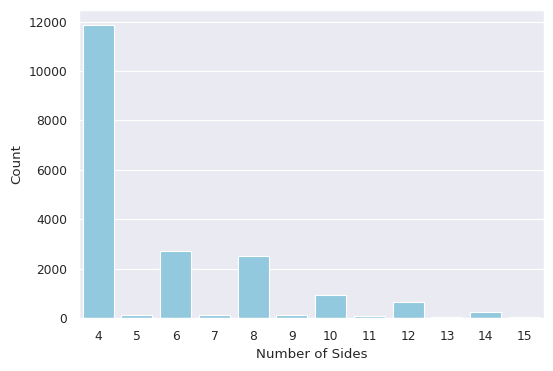

In [77]:
data['sides'] = data.geometry.apply(lambda geom: len(geom.exterior.coords) - 1)

sides = data['sides'].value_counts().sort_index().loc[:15]
sides_counts_df = pd.DataFrame({'Sides': sides.index, 'Count': sides.values})

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=sides_counts_df, x='Sides', y='Count', color='skyblue')
ax.set(xlabel='Number of Sides')
plt.show()

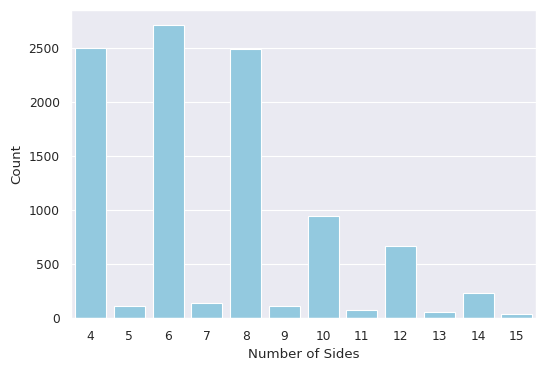

In [79]:
data = data.drop(data[data.sides == 4].index[2500:])

sides = data['sides'].value_counts().sort_index().loc[:15]
sides_counts_df = pd.DataFrame({'Sides': sides.index, 'Count': sides.values})

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=sides_counts_df, x='Sides', y='Count', color='skyblue')
ax.set(xlabel='Number of Sides')
plt.show()

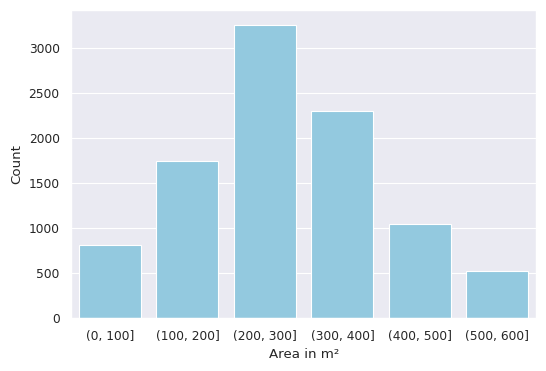

In [80]:
data_projected = data.to_crs('EPSG:3857')

data_projected['area_sqm'] = data_projected.geometry.area
data['area_sqm'] = data_projected['area_sqm'].values

area_bins = [0, 100, 200, 300, 400, 500, 600] 
data_projected['area_category'] = pd.cut(data_projected['area_sqm'], bins=area_bins)

area_counts = data_projected['area_category'].value_counts().sort_index()
area_counts_df = pd.DataFrame({'Area': area_counts.index, 'Count': area_counts.values})

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=area_counts_df, x='Area', y='Count', color='skyblue')
ax.set(xlabel='Area in m²')
plt.show()

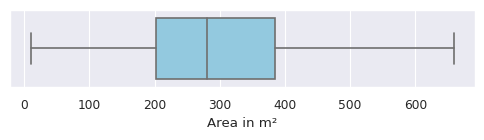

In [81]:
fig, ax = plt.subplots(figsize=(6, 1))
sns.boxplot(data=data_projected, x='area_sqm', color='skyblue', showfliers=False)
ax.set(xlabel='Area in m²')
plt.show()

In [99]:
def calculate_interior_angles(geometry):
    coords = np.array(geometry.exterior.coords[:-1])
    num_points = coords.shape[0]
    interior_angles = []
    for i in range(num_points):
        prev_point = coords[(i-1) % num_points]
        current_point = coords[i]
        next_point = coords[(i+1) % num_points]

        v1 = prev_point - current_point
        v2 = next_point - current_point

        angle = np.degrees(np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0]))
        angle = (angle + 360) % 360  # Ensure positive angle
        interior_angles.append(angle)
    return interior_angles

def to_ext_angle(int_angles):
    ext_angles = []
    for angle in int_angles:
        ext_angles.append(180 - angle)
    return ext_angles  
    
data_projected['int_angles'] = data_projected.geometry.apply(calculate_interior_angles)
data_projected['ext_angles'] = data_projected['int_angles'].apply(to_ext_angle)

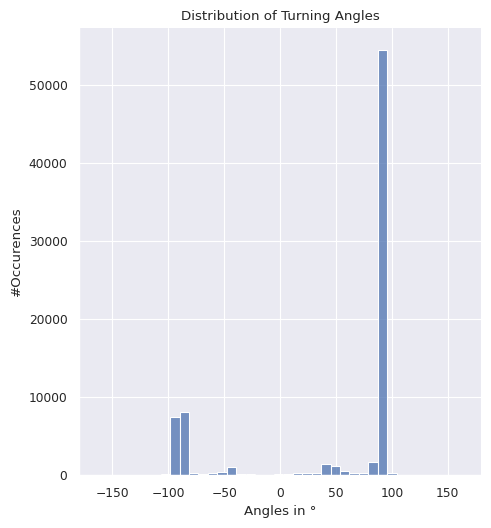

In [100]:
turning_angles = data_projected['ext_angles']

# Flatten the nested list of angles into a single list
angles_flat = [a for sublist in turning_angles for a in sublist]

# Create a distribution plot using seaborn's distplot
sns.displot(angles_flat, bins=36, kde=False)
plt.xlim(-180, 180)
plt.xlabel('Angles in °')
plt.ylabel('#Occurences')
plt.title('Distribution of Turning Angles')
plt.show()

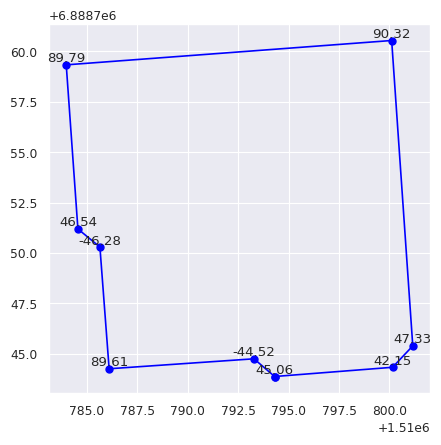

In [134]:
sample_row = data_projected.sample(n=1)

ext_angles = sample_row['ext_angles'].iloc[0]


fig, ax = plt.subplots()

# Plot the polygon
sample_row.plot(ax=ax, facecolor='none')

# Plot the individual vertices
x, y = sample_row.geometry.iloc[0].exterior.xy
ax.plot(x, y, marker='o', color='blue', markersize=5)
for i, (xi, yi) in enumerate(zip(x[:-1], y[:-1])):
    ax.text(xi, yi, f'{ext_angles[i]:.2f}', ha='center', va='bottom')

plt.show()

In [125]:
# Convert turning angles to comma-separated strings, to store in file
data['ext_angles'] = data_projected['ext_angles'].apply(lambda angles: ', '.join(map(str, angles))).values

data.head()

,FID,geometry,sides,area_sqm,ext_angles
0,12,"POLYGON ((13.61060 52.50869, 13.61065 52.50885...",4,483.475147,"89.99376915302145, 90.006270849136, 89.9937338..."
1,13,"POLYGON ((13.60783 52.50827, 13.60792 52.50846...",4,537.033611,"90.00223908096831, 89.9853808254253, 90.031396..."
2,14,"POLYGON ((13.60810 52.50852, 13.60797 52.50854...",4,544.718253,"90.02760765133007, 89.98906360790124, 90.02347..."
3,15,"POLYGON ((13.60730 52.50834, 13.60717 52.50835...",4,530.393384,"90.00455779889927, 89.99543715689634, 90.00461..."
4,16,"POLYGON ((13.60741 52.50861, 13.60727 52.50863...",4,541.766198,"90.00513902339259, 89.9948558164383, 90.005199..."


In [135]:
data.to_file('buildings_core_dataset.shp') 